In [3]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.0 MB/s eta 0:00:00


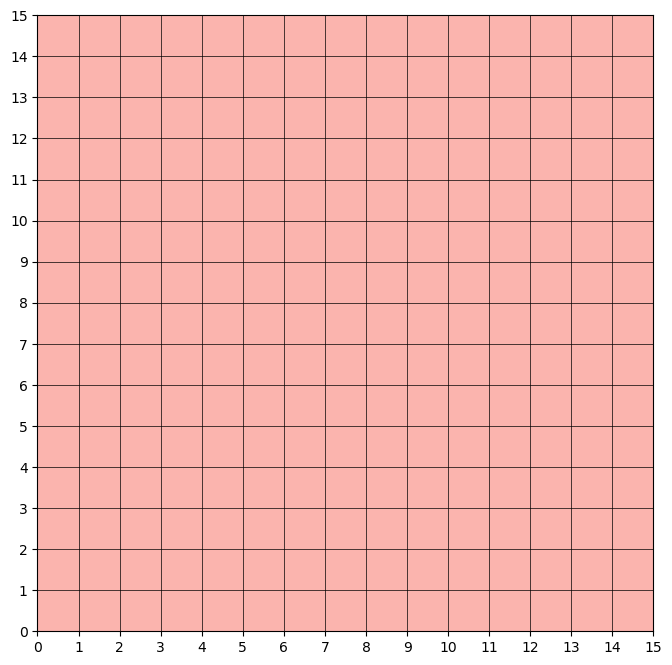

interactive(children=(IntSlider(value=7, description='x', max=14), IntSlider(value=7, description='y', max=14)…

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import display, clear_output
from game import Game
from agent import Agent, User
from model1 import Residual_CNN
import config
import torch

# 게임 초기화
game = Game()
board_size = int(game.state_size ** 0.5)  # 보드 크기 계산
game.reset()  # 초기화

# 이미 학습된 모델 로드
model_path = "/home/aikusrv01/omok/torch_omok_test/DeepReinforcementLearning/models/gomokucurr_0025.pt"  # 학습된 모델 파일 경로

ai_nn = Residual_CNN(
    config.REG_CONST,
    config.LEARNING_RATE,
    game.input_shape,
    game.action_size,
    config.HIDDEN_CNN_LAYERS,
)
ai_nn.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
ai_nn.eval()  # 평가 모드 설정

# AI Agent 초기화
ai = Agent("AI", game.state_size, game.action_size, config.MCTS_SIMS, config.CPUCT, ai_nn, device=None)

# 보드 초기화
board = np.zeros((board_size, board_size), dtype=int)

# 승리 체크 함수
def check_winner():
    if game.gameState.isEndGame == 1:
        winner = "User (Black)" if game.gameState.playerTurn == -1 else "AI (White)"
        return winner
    return None

# 보드 시각화 함수
def render_board():
    clear_output(wait=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(np.zeros((board_size, board_size)), cmap="gray", extent=(0, board_size, 0, board_size))
    plt.xticks(range(board_size))
    plt.yticks(range(board_size))
    plt.grid(color="black", linestyle="-", linewidth=1)

    for i in range(board_size):
        for j in range(board_size):
            if board[i, j] == 1:  # Black stone
                plt.plot(j + 0.5, board_size - i - 0.5, 'ko', markersize=20)
            elif board[i, j] == -1:  # White stone
                plt.plot(j + 0.5, board_size - i - 0.5, 'wo', markersize=20)

    plt.show() 

# 유저의 턴 처리 함수
def user_turn(row, col):
    global board
    action = row * board_size + col

    if game.gameState.board[action] != 0:
        print("Cell is already occupied. Choose another cell.")
        return

    # 유저가 돌을 놓음
    game.step(action)
    board[row, col] = 1

    winner = check_winner()
    if winner:
        render_board()
        print(f"Game Over! {winner} wins!")
        return

    # AI의 턴
    ai_action, _, _, _ = ai.act(game.gameState, tau=0)
    ai_row, ai_col = divmod(ai_action, board_size)
    game.step(ai_action)
    board[ai_row, ai_col] = -1

    winner = check_winner()
    render_board()
    if winner:
        print(f"Game Over! {winner} wins!")

# 인터랙티브 UI 설정
def interactive_game(row, col):
    user_turn(row, col)

# 위젯 생성
interact(
    interactive_game,
    row=(0, board_size - 1, 1),
    col=(0, board_size - 1, 1)
)

render_board()
